## Imports ##

In [8]:
pip install iTransformer

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.4/872.4 kB 10.3 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import pickle
import json
import joblib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mne

from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,Matern,RationalQuadratic,ExpSineSquared
from sklearn.metrics import classification_report, accuracy_score

from processing.Processing_EEG import process_eeg
from processing.Processing_NIRS import process_nirs

from utilities.Read_Data import read_subject_raw_nirs, read_subject_raw_eeg
from utilities.utilities import translate_channel_name_to_ch_id, find_sections, spatial_zscore

from matplotlib.backends.backend_pdf import PdfPages

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Constants ##

In [2]:
BASE_PATH = '/scratch/ak10514/super-resolution'

ROOT_DIRECTORY_EEG = os.path.join(BASE_PATH, 'data/raw/eeg/')
ROOT_DIRECTORY_NIRS = os.path.join(BASE_PATH, 'data/raw/nirs/')

# Trial order
TRIAL_TO_CHECK_NIRS = {'VP001': {
                            'nback': ['2016-05-26_007', '2016-05-26_008', '2016-05-26_009',],
                            'gonogo': ['2016-05-26_001', '2016-05-26_002', '2016-05-26_003',],
                            'word': ['2016-05-26_004', '2016-05-26_005', '2016-05-26_006',]
                        },
                        'VP002': {
                            'nback': ['2016-05-26_016', '2016-05-26_017', '2016-05-26_018',],
                            'gonogo': ['2016-05-26_010', '2016-05-26_011', '2016-05-26_012',],
                            'word': ['2016-05-26_013', '2016-05-26_014', '2016-05-26_015',]
                        },
                        'VP003': {
                            'nback': ['2016-05-27_001', '2016-05-27_002', '2016-05-27_003',],
                            'gonogo': ['2016-05-27_007', '2016-05-27_008', '2016-05-27_009',],
                            'word': ['2016-05-27_004', '2016-05-27_005', '2016-05-27_006',]
                        },
                        'VP004': {
                            'nback': ['2016-05-30_001', '2016-05-30_002', '2016-05-30_003'],
                            'gonogo': ['2016-05-30_007', '2016-05-30_008', '2016-05-30_009'],
                            'word': ['2016-05-30_004', '2016-05-30_005', '2016-05-30_006']
                        },
                        'VP005': {
                            'nback': ['2016-05-30_010', '2016-05-30_011', '2016-05-30_012'],
                            'gonogo': ['2016-05-30_016', '2016-05-30_017', '2016-05-30_018'],
                            'word': ['2016-05-30_013', '2016-05-30_014', '2016-05-30_015']
                        },
                        'VP006': {
                            'nback': ['2016-05-31_001', '2016-05-31_002', '2016-05-31_003'],
                            'gonogo': ['2016-05-31_007', '2016-05-31_008', '2016-05-31_009'],
                            'word': ['2016-05-31_004', '2016-05-31_005', '2016-05-31_006']
                        },
                        'VP007': {
                            'nback': ['2016-06-01_001', '2016-06-01_002', '2016-06-01_003'],
                            'gonogo': ['2016-06-01_007', '2016-06-01_008', '2016-06-01_009'],
                            'word': ['2016-06-01_004', '2016-06-01_005', '2016-06-01_006']
                        },
                        'VP008': {
                            'nback': ['2016-06-02_001', '2016-06-02_002', '2016-06-02_003'],
                            'gonogo': ['2016-06-02_007', '2016-06-02_008', '2016-06-02_009'],
                            'word': ['2016-06-02_004', '2016-06-02_005', '2016-06-02_006']
                        },
                        'VP009': {
                            'nback': ['2016-06-02_010', '2016-06-02_011', '2016-06-02_012'],
                            'gonogo': ['2016-06-02_016', '2016-06-02_017', '2016-06-02_018'],
                            'word': ['2016-06-02_013', '2016-06-02_014', '2016-06-02_015']
                        },
                        'VP010': {
                            'nback': ['2016-06-03_001', '2016-06-03_002', '2016-06-03_003'],
                            'gonogo': ['2016-06-03_007', '2016-06-03_008', '2016-06-03_009'],
                            'word': ['2016-06-03_004', '2016-06-03_005', '2016-06-03_006']
                        },
                        'VP011': {
                            'nback': ['2016-06-03_010', '2016-06-03_011', '2016-06-03_012'],
                            'gonogo': ['2016-06-03_016', '2016-06-03_017', '2016-06-03_018'],
                            'word': ['2016-06-03_013', '2016-06-03_014', '2016-06-03_015']
                        },'VP012': {
                            'nback': ['2016-06-06_001', '2016-06-06_002', '2016-06-06_003'],
                            'gonogo': ['2016-06-06_007', '2016-06-06_008', '2016-06-06_009'],
                            'word': ['2016-06-06_004', '2016-06-06_005', '2016-06-06_006']
                        },'VP013': {
                            'nback': ['2016-06-06_010', '2016-06-06_011', '2016-06-06_012'],
                            'gonogo': ['2016-06-06_016', '2016-06-06_017', '2016-06-06_018'],
                            'word': ['2016-06-06_013', '2016-06-06_014', '2016-06-06_015']
                        },'VP014': {
                            'nback': ['2016-06-07_001', '2016-06-07_002', '2016-06-07_003'],
                            'gonogo': ['2016-06-07_007', '2016-06-07_008', '2016-06-07_009'],
                            'word': ['2016-06-07_004', '2016-06-07_005', '2016-06-07_006']
                        },'VP015': {
                            'nback': ['2016-06-07_010', '2016-06-07_011', '2016-06-07_012'],
                            'gonogo': ['2016-06-07_016', '2016-06-07_017', '2016-06-07_018'],
                            'word': ['2016-06-07_013', '2016-06-07_014', '2016-06-07_015']
                        },'VP016': {
                            'nback': ['2016-06-08_001', '2016-06-08_002', '2016-06-08_003'],
                            'gonogo': ['2016-06-08_007', '2016-06-08_008', '2016-06-08_009'],
                            'word': ['2016-06-08_004', '2016-06-08_005', '2016-06-08_006']
                        },'VP017': {
                            'nback': ['2016-06-09_001', '2016-06-09_002', '2016-06-09_003'],
                            'gonogo': ['2016-06-09_007', '2016-06-09_008', '2016-06-09_009'],
                            'word': ['2016-06-09_004', '2016-06-09_005', '2016-06-09_006']
                        },'VP018': {
                            'nback': ['2016-06-10_001', '2016-06-10_002', '2016-06-10_003'],
                            'gonogo': ['2016-06-10_007', '2016-06-10_008', '2016-06-10_009'],
                            'word': ['2016-06-10_004', '2016-06-10_005', '2016-06-10_006']
                        },'VP019': {
                            'nback': ['2016-06-13_001', '2016-06-13_002', '2016-06-13_003'],
                            'gonogo': ['2016-06-13_007', '2016-06-13_008', '2016-06-13_009'],
                            'word': ['2016-06-13_004', '2016-06-13_005', '2016-06-13_006']
                        },'VP020': {
                            'nback': ['2016-06-14_001', '2016-06-14_002', '2016-06-14_003'],
                            'gonogo': ['2016-06-14_007', '2016-06-14_008', '2016-06-14_009'],
                            'word': ['2016-06-14_004', '2016-06-14_005', '2016-06-14_006']
                        },'VP021': {
                            'nback': ['2016-06-14_010', '2016-06-14_011', '2016-06-14_012'],
                            'gonogo': ['2016-06-14_016', '2016-06-14_017', '2016-06-14_018'],
                            'word': ['2016-06-14_013', '2016-06-14_014', '2016-06-14_015']
                        },'VP022': {
                            'nback': ['2016-06-15_001', '2016-06-15_002', '2016-06-15_003'],
                            'gonogo': ['2016-06-15_007', '2016-06-15_008', '2016-06-15_009'],
                            'word': ['2016-06-15_004', '2016-06-15_005', '2016-06-15_006']
                        },'VP023': {
                            'nback': ['2016-06-16_001', '2016-06-16_002', '2016-06-16_003'],
                            'gonogo': ['2016-06-16_007', '2016-06-16_008', '2016-06-16_009'],
                            'word': ['2016-06-16_004', '2016-06-16_005', '2016-06-16_006']
                        },'VP024': {
                            'nback': ['2016-06-16_010', '2016-06-16_011', '2016-06-16_012'],
                            'gonogo': ['2016-06-16_016', '2016-06-16_017', '2016-06-16_018'],
                            'word': ['2016-06-16_013', '2016-06-16_014', '2016-06-16_015']
                        },
                        'VP025': {
                            'nback': ['2016-06-17_010', '2016-06-17_011', '2016-06-17_012',],
                            'gonogo': ['2016-06-17_016', '2016-06-17_017', '2016-06-17_018',],
                            'word': ['2016-06-17_013', '2016-06-17_014', '2016-06-17_015',]
                        },
                        'VP026': {
                            'nback': ['2016-07-11_001', '2016-07-11_002', '2016-07-11_003',],
                            'gonogo': ['2016-07-11_007', '2016-07-11_008', '2016-07-11_009',],
                            'word': ['2016-07-11_004', '2016-07-11_005', '2016-07-11_006',]
                        }
                    }

# Task translation dictionaries
EEG_EVENT_TRANSLATIONS = {
            'nback': {
                'Stimulus/S 16': '0-back target',
                'Stimulus/S 48': '2-back target',
                'Stimulus/S 64': '2-back non-target',
                'Stimulus/S 80': '3-back target',
                'Stimulus/S 96': '3-back non-target',
                'Stimulus/S112': '0-back session',
                'Stimulus/S128': '2-back session',
                'Stimulus/S144': '3-back session'},
            'gonogo': {
                'Stimulus/S 16': 'go',
                'Stimulus/S 32': 'nogo',
                'Stimulus/S 48': 'gonogo session'},
            'word': {
                'Stimulus/S 16': 'verbal_fluency',
                'Stimulus/S 32': 'baseline'}
}
NIRS_EVENT_TRANSLATIONS = {
    'nback': {
        '7.0': '0-back session',
        '8.0': '2-back session',
        '9.0': '3-back session'},
    'gonogo': {
        '3.0': 'gonogo session'},
    'word': {
        '1.0': 'verbal_fluency',
        '2.0': 'baseline'}
}

# Sub tasks to crop times to for same length
TASK_STIMULOUS_TO_CROP = {'nback': ['0-back session', '2-back session', '3-back session'],
                            'gonogo': ['gonogo session'],
                            'word': ['verbal_fluency', 'baseline']
                            }

# EEG Coordinates
EEG_COORDS = {'FP1':(-0.3090,0.9511,0.0001), #Fp1
                'AFF5':(-0.5417,0.7777,0.3163), #AFF5h
                'AFz':(0.0000,0.9230,0.3824),
                'F1':(-0.2888,0.6979,0.6542),
                'FC5':(-0.8709,0.3373,0.3549),
                'FC1':(-0.3581,0.3770,0.8532),
                'T7':(-1.0000,0.0000,0.0000),
                'C3':(-0.7066,0.0001,0.7066),
                'Cz':(0.0000,0.0002,1.0000),
                'CP5':(-0.8712,-0.3372,0.3552),
                'CP1':(-0.3580,-0.3767,0.8534),
                'P7':(-0.8090,-0.5878,-0.0001),
                'P3':(-0.5401,-0.6724,0.5045),
                'Pz':(0.0000,-0.7063,0.7065),
                'POz':(0.0000,-0.9230,0.3824),
                'O1':(-0.3090,-0.9511,0.0000),
                'FP2':(0.3091,0.9511,0.0000), #Fp2
                'AFF6':(0.5417,0.7777,0.3163), #AFF6h
                'F2':(0.2888,0.6979,0.6542),
                'FC2':(0.3581,0.3770,0.8532),
                'FC6':(0.8709,0.3373,0.3549),
                'C4':(0.7066,0.0001,0.7066),
                'T8':(1.0000,0.0000,0.0000),
                'CP2':(0.3580,-0.3767,0.8534),
                'CP6':(0.8712,-0.3372,0.3552),
                'P4':(0.5401,-0.6724,0.5045),
                'P8':(0.8090,-0.5878,-0.0001),
                'O2':(0.3090,-0.9511,0.0000),
                'TP9':(-0.8777,-0.2852,-0.3826),
                'TP10':(0.8777,-0.2853,-0.3826),
                
                'Fp1':(-0.3090,0.9511,0.0001),
                'AFF5h':(-0.5417,0.7777,0.3163),
                'Fp2':(0.3091,0.9511,0.0000),
                'AFF6h':(0.5417,0.7777,0.3163),}

# NIRS Ccoordinates
NIRS_COORDS = {
    'AF7':(-0.5878,0.809,0),
    'AFF5':(-0.6149,0.7564,0.2206),
    'AFp7':(-0.454,0.891,0),
    'AF5h':(-0.4284,0.875,0.2213),
    'AFp3':(-0.2508,0.9565,0.1438),
    'AFF3h':(-0.352,0.8111,0.4658),
    'AF1':(-0.1857,0.915,0.3558),
    'AFFz':(0,0.8312,0.5554),
    'AFpz':(0,0.9799,0.1949),
    'AF2':(0.1857,0.915,0.3558),
    'AFp4':(0.2508,0.9565,0.1437),
    'FCC3':(-0.6957,0.1838,0.6933),
    'C3h':(-0.555,0.0002,0.8306),
    'C5h':(-0.8311,0.0001,0.5552),
    'CCP3':(-0.6959,-0.1836,0.6936),
    'CPP3':(-0.6109,-0.5259,0.5904),
    'P3h':(-0.4217,-0.6869,0.5912),
    'P5h':(-0.6411,-0.6546,0.3985),
    'PPO3':(-0.4537,-0.796,0.3995),
    'AFF4h':(0.352,0.8111,0.4658),
    'AF6h':(0.4284,0.875,0.2212),
    'AFF6':(0.6149,0.7564,0.2206),
    'AFp8':(0.454,0.891,0),
    'AF8':(0.5878,0.809,0),
    'FCC4':(0.6957,0.1838,0.6933),
    'C6h':(0.8311,0.0001,0.5552),
    'C4h':(0.555,0.0002,0.8306),
    'CCP4':(0.6959,-0.1836,0.6936),
    'CPP4':(0.6109,-0.5258,0.5904),
    'P6h':(0.6411,-0.6546,0.3985),
    'P4h':(0.4216,-0.687,0.5912),
    'PPO4':(0.4537,-0.796,0.3995),
    'PPOz':(0,-0.8306,0.5551),
    'PO1':(-0.1858,-0.9151,0.3559),
    'PO2':(0.1859,-0.9151,0.3559),
    'POOz':(0,-0.9797,0.1949)}

# EEG Channels names
EEG_CHANNEL_NAMES = ['FP1', 
                    # 'AFF5h', 
                    'AFz', 
                    'F1', 
                    'FC5', 
                    'FC1', 
                    'T7', 
                    'C3', 
                    'Cz', 
                    'CP5', 
                    'CP1', 
                    'P7', 
                    'P3', 
                    'Pz', 
                    'POz', 
                    'O1',  
                    'FP2', 
                    # 'AFF6h',
                    'F2', 
                    'FC2', 
                    'FC6', 
                    'C4', 
                    'T8', 
                    'CP2', 
                    'CP6', 
                    'P4', 
                    'P8', 
                    'O2',]

## Model Definitions

In [3]:
def get_gpc_model():
    print('GPC')
    # kernel = 1.0 * RBF(length_scale=0.0562, length_scale_bounds=(1e-05, 100000.0)) + WhiteKernel(
    #     noise_level=0.316, noise_level_bounds=(1e-25, 10.0)
    # )
    kernel = (1.0 * 
              Matern(length_scale=0.0562, length_scale_bounds=(1e-05, 5000.0), nu=0.5) * 
              ExpSineSquared(length_scale=10.0, periodicity=1.5, length_scale_bounds=(1e-05, 5000.0), periodicity_bounds=(1e-05, 5000.0)) + 
              WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-05, 5000.0)
    )
    )
    gp = GaussianProcessClassifier(kernel=kernel, random_state=42)

    # print parameters
    print(gp.get_params())

    params_model = [{
        'model': [gp],
        # 'model__alpha': np.logspace(-2, 4, 5),
        'model__kernel__k1__k1__k1__constant_value_bounds': [(1e-05, 5000.0)],

        # 'model__kernel__k1__k1__k2__nu': [0.5, 1.5, 2.5, 3.5],
        # 'model__kernel__k1__k1__k2__length_scale': np.logspace(-2, 1, 5),
        # 'model__kernel__k1__k1__k2__length_scale_bounds': [(1e-10, 1e10), (1e-10, 1e15)],
        
        # 'model__kernel__k1__k2__periodicity': [0.5, 1.0, 1.5, 2.0],
        # 'model__kernel__k1__k2__length_scale': np.logspace(-2, 1, 5),
        # 'model__kernel__k1__k2__length_scale_bounds': [(1e-5, 1e5), (1e-10, 1e10)],
        # 'model__kernel__k1__k2__periodicity_bounds': [(1e-05, 150000.0), (1e-05, 200000.0)],

        # 'model__kernel__k2__noise_level': np.logspace(-2, 1, 5),
        # 'model__kernel__k2__noise_level_bounds': [(1e-300, 1e1)],

        # 'model__normalize_y': [True, False],
    }]
    return params_model

class LSTMModel(nn.Module):
    def __init__(self, input_features, hidden_dim, output_steps):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_features, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_steps)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # We take the output of the last LSTM time step
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

In [4]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(TransformerEncoder, self).__init__()
        self.encoder_layers = nn.TransformerEncoderLayer(input_size, nhead=7, dim_feedforward=hidden_size)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layers, num_layers=num_layers)
    
    def forward(self, src):
        src = src.permute(1, 0, 2)  # Permute input to (sequence_length, batch_size, input_size)
        encoder_output = self.transformer_encoder(src)
        return encoder_output.permute(1, 0, 2)  # Permute output back to (batch_size, sequence_length, input_size)

# Define the decoder
class Decoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(Decoder, self).__init__()
        self.decoder = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        # Ensure the input tensor has the expected dimensions
        if len(x.size()) != 3:
            raise ValueError("Input tensor must be 3-dimensional (batch_size, sequence_length, input_size)")

        # Reshape the input tensor to (batch_size * sequence_length, input_size)
        batch_size, sequence_length, input_size = x.size()
        x_reshaped = x.reshape(-1, input_size)
        
        # Apply the linear transformation
        output = self.decoder(x_reshaped)
        
        # Reshape the output back to (batch_size, sequence_length, output_size)
        output = output.reshape(batch_size, sequence_length, -1)
        return output

# Define the model
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TransformerModel, self).__init__()
        self.encoder = TransformerEncoder(input_size, hidden_size, num_layers)
        # Adjusted the decoder to take input_size and output_size as arguments
        self.decoder = Decoder(input_size, output_size)
    
    def forward(self, x):
        encoded = self.encoder(x)
        # Use the decoder to transform the encoded output
        decoded = self.decoder(encoded)
        return decoded

## Brain Channel Plot

In [5]:
# plot_eeg_nirs_brain(
#     eeg_task_names['nback'], 
#     eeg_filtered_waves_epoch['full'],
#     nirs_epochs,
#     eeg_coords=EEG_COORDS, 
#     nirs_cords=NIRS_COORDS)
# plt.show()

## Data Formatting ##

In [6]:
# Generator function to get data
def process_sections_generator(section_indexes_nirs, 
                     section_indexes_eeg, 
                     upscale_rate, 
                     hbo_data, 
                     eeg_data, 
                     hbr_data=None,
                     do_interpolation=False):
    for section_index_nirs, section_index_eeg in zip(section_indexes_nirs, section_indexes_eeg):
        hbo_section_data = hbo_data[:, section_index_nirs[0]:section_index_nirs[1]]
        y_full = eeg_data[:, section_index_eeg[0]:section_index_eeg[1]] # eeg_section_data

        if hbr_data is not None:
            hbr_section_data = hbr_data[:, section_index_nirs[0]:section_index_nirs[1]]
            stacked_fnirs = np.vstack([hbo_section_data, hbr_section_data])
        else:
            stacked_fnirs = hbo_section_data

        # Perform time correction
        y_length = y_full.shape[1]

        # Find the nearest lower and higher multiples of upscale_rate
        lower_multiple = y_length - (y_length % upscale_rate)
        higher_multiple = lower_multiple + upscale_rate if y_length % upscale_rate != 0 else lower_multiple
        exact_multiple = upscale_rate*stacked_fnirs.shape[1]

        # Determine which multiple is closest to the original length
        y_new_length = higher_multiple
        if (y_length - lower_multiple) <= (higher_multiple - y_length):
            y_new_length = lower_multiple
        # Check if the new length is longer than the fnirs data and adjust
        if exact_multiple < y_new_length:
            y_new_length = exact_multiple
        else:
            stacked_fnirs = stacked_fnirs[:,:int(y_new_length/upscale_rate)]

        y_full = y_full[:,:y_new_length] # make eeg upscale rate times longer
        x_full = stacked_fnirs

        if do_interpolation:
            # Interpolation
            # We need to interpolate nirs to have the same number of points as eeg
            nirs_old = np.linspace(0, 1, stacked_fnirs.shape[1])  # Original sampling points for nirs
            nirs_new = np.linspace(0, 1, y_full.shape[1])  # New sampling points to match the length of eeg

            # Perform cubic interpolation
            x_full = np.zeros((stacked_fnirs.shape[0], y_full.shape[1]))
            for channel in range(stacked_fnirs.shape[0]):
                cs = CubicSpline(nirs_old, stacked_fnirs[channel])
                x_full[channel] = cs(nirs_new)
        
        # Zscore normilization
        z_sigma_max=3200
        # z_sigma_max=2200
        z_sigma_min=1

        x_full = spatial_zscore(x_full, z_sigma_max)-spatial_zscore(x_full ,z_sigma_min)
        y_full = spatial_zscore(y_full,z_sigma_max)-spatial_zscore(y_full,z_sigma_min)

        yield x_full, y_full

def get_xy_coords_signal_prediction_segmented(hbo_mne, hbr_mne, eeg_mne, eeg_sample_rate, fnirs_sampling_rate, offset, eeg_dt, nirs_dt, use_hbr=True):

    events_nirs, single_events_dict_nirs = mne.events_from_annotations(hbo_mne)
    events_eeg, single_events_dict_eeg = mne.events_from_annotations(eeg_mne)

    # Get session ids
    session_keys = [value for key,value in single_events_dict_nirs.items() if key.startswith('session')]
    session_keys.sort()
    print(session_keys)

    # Split processing into sessions
    section_indexes_nirs, section_indexes_eeg = find_sections(events_nirs, events_eeg, session_keys)

    # Get all data
    hbo_mne_all_data = hbo_mne.get_data()
    eeg_mne_all_data = eeg_mne.get_data()

    hbr_mne_all_data = None
    if use_hbr:
        hbr_mne_all_data = hbr_mne.get_data()

    upscale_rate = int(np.rint(eeg_sample_rate/fnirs_sampling_rate))

    x_full_list = []
    y_full_list = []
    for x_full, y_full in process_sections_generator(section_indexes_nirs, 
                                           section_indexes_eeg, 
                                           upscale_rate, 
                                           hbo_mne_all_data, 
                                           eeg_mne_all_data, 
                                           hbr_mne_all_data):
        x_full_list.append(x_full)
        y_full_list.append(y_full)

    x_full = np.hstack(x_full_list)
    y_full = np.hstack(y_full_list)

    print(f'x_z final: {x_full.shape}')
    print(f'y_z final: {y_full.shape}')

    nirs_index_dt = int(np.rint(fnirs_sampling_rate*nirs_dt))
    eeg_index_dt = int(np.rint(eeg_sample_rate*eeg_dt))

    y_full_list = []
    x_full_list = []
    for eeg_index in range(0, y_full.shape[1], eeg_index_dt):
        nirs_index = int(np.rint((eeg_index/eeg_sample_rate)*fnirs_sampling_rate))
        if nirs_index+nirs_index_dt > x_full.shape[1] or eeg_index+eeg_index_dt > y_full.shape[1]:
            break
        x_full_list.append(x_full[:,nirs_index:nirs_index+nirs_index_dt])
        y_full_list.append(y_full[:,eeg_index:eeg_index+eeg_index_dt])

    x_full = np.array(x_full_list)
    y_full = np.array(y_full_list)

    if offset != 0:
        y_full = y_full[:,:-offset]
        x_full = x_full[:,offset:]

    print(f' x End: {x_full.shape}')
    print(f' y End: {y_full.shape}')

    return x_full, y_full


## Pipeline ##

In [7]:
def peak_signal_to_noise_ratio_score(estimator, x, y):
    """Compute the peak signal to noise ratio (PSNR) for a signal.
    Parameters
    ----------
    true : ndarray
        Ground-truth image.
    pred : ndarray
        Reconstructed image.
    Returns
    -------
    psnr : float
        The PSNR metric.
    """
    pred = estimator.predict(x)

    y = np.array(y, dtype=np.float64)
    pred = np.array(pred, dtype=np.float64)

    mse = np.mean((y - pred) ** 2)
    if mse == 0:
        return np.inf

    return 10 * np.log10(np.max(y) ** 2 / mse)

def start_pipeline_signal_prediction( 
                X,
                y,
                model,
                train_size=5000,
                test_size=1000,
                save_model = False,
                save_model_name = '',
                model_path = './output/'
):
    model.fit(X, y, epochs=200, verbose=1)

    train_index = train_size+1
    X_train, y_train = X[:train_index], y[:train_index]
    X_test, y_test = X[train_index:train_index+test_size], y[train_index:train_index+test_size]

    print(y_train.shape)
    print(y_test.shape)

    X_train, _, y_train, _  = train_test_split(
        X_train, 
        y_train, 
        train_size=train_size,
        test_size=1,
        shuffle=False)

    print(f'train: x:{X_train.shape} y:{y_train.shape}')
    print(f'test: x:{X_test.shape} y:{y_test.shape}')


    model.fit(X_train, y_train, epochs=200, verbose=1)

    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    print(f"train:{score_train}, test:{score_test}")

    psnr_train = peak_signal_to_noise_ratio_score(model, X_train, y_train)
    psnr_test = peak_signal_to_noise_ratio_score(model, X_test, y_test)
    print(f"psnr_train:{psnr_train}, psnr_test:{psnr_test}")

    if save_model:
        save_model_name = f'train_{score_train:.2f}_test_{score_test:.2f}_{save_model_name}'
        file_path = os.path.join(model_path, save_model_name)
        if not os.path.exists(file_path):
            os.makedirs(file_path)
    
    return model

## Parameters ##

In [8]:
## Subject/Trial Parameters ##
subject_ids = np.arange(1,14) # 1-27
subjects = []
for i in subject_ids:
    subjects.append(f'VP{i:03d}')

tasks = ['nback','gonogo','word']


# Epoch size
T_MIN_EEG, T_MAX_EEG = -0.5, 0.9
T_MIN_NIRS, T_MAX_NIRS = -1, 1


## SR Parameters ##

fnirs_sample_rate = 10

# EEG Downsampling rate
eeg_sample_rate = 10

# Time window (seconds)
eeg_dt = 1
nirs_dt = 5
offset = 0

# Train/Test Size
# train_size = 100000
# test_size = 20000

# training loop
n_epochs = 5

# Do processing or not
do_processing = True

# Redo preprocessing pickle files, TAKES A LONG TIME 
redo_preprocessing = False

# Redo data formating pickle files, TAKES A LONG TIME
redo_data_formatting = False

# Define channels to use
# nirs_channels_to_use_base = list(NIRS_COORDS.keys())
#nirs_channels_to_use_base = ['AF7','AFF5','AFp5h','AFp3','C6h','C4h','CCP4','CPP4']
nirs_channels_to_use_base = ['AF7']
# eeg_channels_to_use = EEG_CHANNEL_NAMES
eeg_channels_to_use = ['P7'] 

## Processing

After reading in the data for each subject, we have to perform a match in the stimulous indexes for each task. This is a limitation in the dataset itself as only session start indexes are labeled in the NIRS data while individual task types are labeled in the EEG data.

After we perform this match we perform signal preprocessing to each NIRS and EEG dataset individually.

### NIRS
NIRS is bandpass filtered between 0 and 5 hz. After we ensure all source channels are within 0.1 cm from the dector to ensure proper calibration of every channel we use. We then convert the raw voltage to optical density measurment. We then apply beer-lambert law to seperate oxyginated and deoxyginated hemoglobin measurments. We then filter out NIRS related noise.
NIRS, measuring hemoglobyn, has a number of physiological interferences that must be filterd out. Cardiac activities such as heartrate has a frequency range of 0.8 to 1.5 Hz, respiratory activities have a frequency range of 0.2-0.5 Hz, and arterial blood pressure changes have a frequency of 0.1 Hz (Mayer waves with very low-frequency volatility of about 0.04 Hz) [32]. Signals related to neural activities in fNIRS are generally at a frequency range of 0.003 to 0.08 Hz. Since there is a potential overlap in neural activity related signals and noise, a discrete wavlett decomposition function was performed to filter overlap. We choose the band between, 0.003 and 0.080.

![Alt text](nirs_processing-1.png)
The above image shows the different levels of the DWF and how the signal was reconstructed to remove noise below level 6.


Lastly we epoch the data based on a designated time of -1 to 10 seconds around each evoked stimulous. This large time window is to capture the delayed response of hemoglobyn changes.

### EEG
EEG is first band pass between 0 and 80 hz. This is because the voltage measurment below 1 hz for EEG is considered unreliable. We then use the EOG channels (which are channels at the base of the ear that just measure environmental noise and eye blinks) and a independent component analysis to filter out environmental noise and eye blinks. This is done manually by comparing the recordings of the EOG channel with the components in the ICA. We then reject any channels with a abnormaly high voltage measurment.

Lastly we epoch the data the same way as NIRS except we use as the EEG voltage response to stimulous is much faster then NIRS. We also seperate out specific band windows for alpha, beta, gamma, delta, and theta. This is to later make features based around these band windows as previous studies have shown that different neural activities accure in each band.

![Alt text](eeg_waves_processing-1.png)

The Above image shows the different bands of voltage data from EEG.

In [9]:
processed_eeg_subject_list = []
processed_eeg_epoch_subject_list = []
processed_nirs_subject_list = []

# Loop for subjects
for subject_id in subjects:
    eeg_pickle_file = os.path.join(ROOT_DIRECTORY_EEG, subject_id, f'{subject_id}_eeg_processed.pkl')
    # eeg_epochs_pickle_file = os.path.join(ROOT_DIRECTORY_EEG, subject_id, f'{subject_id}_eeg_processed_epochs.pkl')
    nirs_pickle_file = os.path.join(ROOT_DIRECTORY_NIRS, subject_id, f'{subject_id}_processed.pkl')
    if (not redo_preprocessing and do_processing and 
        (os.path.exists(eeg_pickle_file)) #and os.path.exists(eeg_epochs_pickle_file))
    ):  
        # voltage
        with open(eeg_pickle_file, 'rb') as file:
            subject_eeg_voltage = pickle.load(file)

        # epochs
        # with open(eeg_epochs_pickle_file, 'rb') as file:
        #     epoch_eeg = pickle.load(file)
    else:
        print(f'Starting eeg processing of {subject_id}')
        raw_eeg_voltage, eeg_events_dict  = read_subject_raw_eeg(
            os.path.join(ROOT_DIRECTORY_EEG, subject_id),
            tasks,
            EEG_EVENT_TRANSLATIONS,
            TASK_STIMULOUS_TO_CROP,
            eeg_coords=EEG_COORDS)
        print(f'eeg_before: {raw_eeg_voltage.get_data().shape}')
        
        subject_eeg_voltage = raw_eeg_voltage
        if do_processing:
            subject_eeg_voltage, epoch_eeg = process_eeg(
                raw_eeg_voltage, 
                T_MIN_EEG, 
                T_MAX_EEG,
                resample=eeg_sample_rate)
            print(f'eeg_after: {subject_eeg_voltage.get_data().shape}')
            
            with open(eeg_pickle_file, 'wb') as file:
                pickle.dump(subject_eeg_voltage, file, pickle.HIGHEST_PROTOCOL)
            # with open(eeg_epochs_pickle_file, 'wb') as file:
            #     pickle.dump(epoch_eeg, file, pickle.HIGHEST_PROTOCOL)

    if (not redo_preprocessing and do_processing and 
        os.path.exists(nirs_pickle_file)
    ):
        with open(nirs_pickle_file, 'rb') as file:
            subject_nirs = pickle.load(file)
    else:
        print(f'Starting nirs processing of {subject_id}')
        raw_nirs_intensity, raw_slope_dict = read_subject_raw_nirs(
            root_directory=os.path.join(ROOT_DIRECTORY_NIRS, subject_id),
            tasks_to_do=tasks,
            trial_to_check=TRIAL_TO_CHECK_NIRS[subject_id],
            nirs_event_translations=NIRS_EVENT_TRANSLATIONS,
            translation_events_dict=eeg_events_dict,
            task_stimulous_to_crop=TASK_STIMULOUS_TO_CROP)
        print(f'nirs_before: {raw_nirs_intensity.get_data().shape}')

        subject_nirs = raw_nirs_intensity
        if do_processing:
            epoch_nirs, nirs_processed_hemoglobin = process_nirs(
                raw_nirs_intensity, 
                T_MIN_NIRS, 
                T_MAX_NIRS,
                resample=None)
            subject_nirs = nirs_processed_hemoglobin
            print(f'nirs_after: {subject_nirs.get_data().shape}')

            with open(nirs_pickle_file, 'wb') as file:
                pickle.dump(subject_nirs, file, pickle.HIGHEST_PROTOCOL)

    if subject_eeg_voltage.info['sfreq'] != eeg_sample_rate:
        subject_eeg_voltage.resample(eeg_sample_rate)
    # if epoch_eeg.info['sfreq'] != eeg_sample_rate:
    #     epoch_eeg.resample(eeg_sample_rate)
    # if subject_nirs.info['sfreq'] != fnirs_sample_rate:
    #     nirs_processed_hemoglobin.resample(fnirs_sample_rate)

    processed_eeg_subject_list.append(subject_eeg_voltage)
    # processed_eeg_epoch_subject_list.append(epoch_eeg)
    processed_nirs_subject_list.append(subject_nirs)
    
eeg_sample_rate = subject_eeg_voltage.info['sfreq']
fnirs_sample_rate = subject_nirs.info['sfreq']

# Concatenate subjects
eeg_processed_voltage = processed_eeg_subject_list[0]
if len(processed_eeg_subject_list) > 1:
    eeg_processed_voltage = mne.concatenate_raws(processed_eeg_subject_list, preload=False).load_data()

# epoch_eeg = processed_eeg_epoch_subject_list[0]
# if len(processed_eeg_epoch_subject_list) > 1:
#     eeg_processed_voltage = mne.concatenate_raws(processed_eeg_epoch_subject_list, preload=False).load_data()

nirs_processed_hemoglobin = processed_nirs_subject_list[0]
if len(processed_nirs_subject_list) > 1:
    # preload = False because mne was throwing a format error without, load after
    nirs_processed_hemoglobin = mne.concatenate_raws(processed_nirs_subject_list, preload=False).load_data()

eeg_filtered_waves = {'full': eeg_processed_voltage.copy()}
if eeg_sample_rate/2 > 4:
    eeg_filtered_waves['delta'] = eeg_processed_voltage.copy().filter(l_freq=0.5, h_freq=4)
if eeg_sample_rate/2 > 8:
    eeg_filtered_waves['theta'] = eeg_processed_voltage.copy().filter(l_freq=4, h_freq=8)
if eeg_sample_rate/2 > 12:
    eeg_filtered_waves['alpha'] = eeg_processed_voltage.copy().filter(l_freq=8, h_freq=12)
if eeg_sample_rate/2 > 30:
    eeg_filtered_waves['beta'] = eeg_processed_voltage.copy().filter(l_freq=12, h_freq=30)
if eeg_sample_rate/2 > 80:
    eeg_filtered_waves['gamma'] = eeg_processed_voltage.copy().filter(l_freq=30, h_freq=80)

Reading 0 ... 613657  =      0.000 ... 61365.700 secs...
Reading 0 ... 639300  =      0.000 ... 61372.798 secs...
Filtering raw data in 117 contiguous segments
Setting up band-pass filter from 0.5 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 4.50 Hz)
- Filter length: 67 samples (6.700 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [10]:
# Predict EEG

# Get NIRS channels to use
nirs_channels_to_use_ids = translate_channel_name_to_ch_id(NIRS_COORDS, nirs_channels_to_use_base, nirs_processed_hemoglobin.ch_names)
print(nirs_channels_to_use_ids)
print(nirs_processed_hemoglobin.ch_names)

# For labeling
nirs_channels_to_use = nirs_channels_to_use_base
# nirs_channels_to_use = [f'{c} hbo' for c in nirs_channels_to_use_ids]+[f'{c} hbr' for c in nirs_channels_to_use_ids]

eeg_voltage_data = eeg_filtered_waves['full'].copy().pick(picks=eeg_channels_to_use)
if do_processing:
    nirs_channels_to_use_hbo = [f'{c} hbo' for c in nirs_channels_to_use_ids]
    nirs_channels_to_use_hbr = [f'{c} hbr' for c in nirs_channels_to_use_ids]
else:
    nirs_channels_to_use_hbo = [f'{c} 760' for c in nirs_channels_to_use_ids]
    nirs_channels_to_use_hbr = [f'{c} 850' for c in nirs_channels_to_use_ids]
    
hbo_data = nirs_processed_hemoglobin.copy().pick(picks=nirs_channels_to_use_hbo)
hbr_data = nirs_processed_hemoglobin.copy().pick(picks=nirs_channels_to_use_hbr)

['S1_D1']
['S1_D1 hbo', 'S1_D1 hbr', 'S1_D2 hbo', 'S1_D2 hbr', 'S1_D14 hbo', 'S1_D14 hbr', 'S2_D1 hbo', 'S2_D1 hbr', 'S2_D3 hbo', 'S2_D3 hbr', 'S3_D1 hbo', 'S3_D1 hbr', 'S3_D2 hbo', 'S3_D2 hbr', 'S3_D3 hbo', 'S3_D3 hbr', 'S3_D4 hbo', 'S3_D4 hbr', 'S4_D2 hbo', 'S4_D2 hbr', 'S4_D4 hbo', 'S4_D4 hbr', 'S4_D5 hbo', 'S4_D5 hbr', 'S5_D3 hbo', 'S5_D3 hbr', 'S5_D4 hbo', 'S5_D4 hbr', 'S5_D6 hbo', 'S5_D6 hbr', 'S6_D4 hbo', 'S6_D4 hbr', 'S6_D5 hbo', 'S6_D5 hbr', 'S6_D6 hbo', 'S6_D6 hbr', 'S6_D7 hbo', 'S6_D7 hbr', 'S7_D5 hbo', 'S7_D5 hbr', 'S7_D7 hbo', 'S7_D7 hbr', 'S7_D10 hbo', 'S7_D10 hbr', 'S8_D6 hbo', 'S8_D6 hbr', 'S8_D7 hbo', 'S8_D7 hbr', 'S9_D7 hbo', 'S9_D7 hbr', 'S9_D9 hbo', 'S9_D9 hbr', 'S9_D10 hbo', 'S9_D10 hbr', 'S10_D9 hbo', 'S10_D9 hbr', 'S10_D10 hbo', 'S10_D10 hbr', 'S10_D11 hbo', 'S10_D11 hbr', 'S10_D12 hbo', 'S10_D12 hbr', 'S11_D5 hbo', 'S11_D5 hbr', 'S11_D10 hbo', 'S11_D10 hbr', 'S11_D12 hbo', 'S11_D12 hbr', 'S12_D11 hbo', 'S12_D11 hbr', 'S12_D12 hbo', 'S12_D12 hbr']


## Signal Prediction

In [11]:
X_full_segmented, y_full_segmented = get_xy_coords_signal_prediction_segmented(
                                                    hbo_data, 
                                                    hbr_data,
                                                    eeg_voltage_data, 
                                                    eeg_sample_rate, 
                                                    fnirs_sample_rate,
                                                    offset,
                                                    eeg_dt=eeg_dt,
                                                    nirs_dt=nirs_dt,
                                                    use_hbr=False)

print(f' X: {X_full_segmented.shape}')
print(f' y: {y_full_segmented.shape}')

Used Annotations descriptions: ['0-back session', '0-back target', '2-back non-target', '2-back session', '2-back target', '3-back non-target', '3-back session', '3-back target', 'Stimulus/S208', 'baseline', 'go', 'gonogo session', 'nogo', 'session_0', 'session_1', 'session_2', 'verbal_fluency']
Used Annotations descriptions: ['0-back session', '0-back target', '2-back non-target', '2-back session', '2-back target', '3-back non-target', '3-back session', '3-back target', 'Stimulus/S208', 'baseline', 'go', 'gonogo session', 'nogo', 'session_0', 'session_1', 'session_2', 'verbal_fluency']
[14, 15, 16]
Elapsed time: 0.18342041969299316 seconds
Elapsed time: 0.00027489662170410156 seconds
Elapsed time: 0.17669463157653809 seconds
Elapsed time: 0.0002486705780029297 seconds
Elapsed time: 0.17672348022460938 seconds
Elapsed time: 0.0002472400665283203 seconds
Elapsed time: 0.17664742469787598 seconds
Elapsed time: 0.0002422332763671875 seconds
Elapsed time: 0.17662596702575684 seconds
Elapse

In [12]:
X_full_segmented.shape

(58865, 1, 52)

In [13]:
y_full_segmented.shape

(58865, 1, 10)

In [14]:
X_full = X_full_segmented.transpose(0,2,1)
y_full = y_full_segmented.transpose(0,2,1)[:,:,0]

In [15]:
X_full.shape

(58865, 52, 1)

In [16]:
y_full.shape

(58865, 10)

In [14]:
X_full.shape

(117611, 52, 7)

In [15]:
y_full.shape

(117611, 10)

In [48]:
X_train, y_train = X_full[:train_index], y_full[:train_index]

In [18]:
test_size = int(X_full.shape[0]*0.2)
train_size = int(X_full.shape[0]-test_size)

train_index = train_size+1
X_test, y_test = X_full[train_index:train_index+test_size], y_full[train_index:train_index+test_size]

In [19]:
# flatten data
X_full = X_full_segmented.transpose(0,2,1)
y_full = y_full_segmented.transpose(0,2,1)[:,:,0]

print(f' X: {X_full.shape}')
print(f' y: {y_full.shape}')

# n_features is the number of features in input data
# output_steps is the number of future steps to predict
n_features = X_full.shape[2]
output_steps = y_full.shape[1]
hidden_dim = 50  # Number of LSTM units

#model = LSTMModel(input_features=n_features, hidden_dim=hidden_dim, output_steps=output_steps)
model = TransformerModel(input_size=n_features, hidden_size=hidden_dim, num_layers=7, output_size = output_steps)

train_index = train_size+1
X_train, y_train = X_full[:train_index], y_full[:train_index]
X_test, y_test = X_full[train_index:train_index+test_size], y_full[train_index:train_index+test_size]

# Convert the numpy arrays to PyTorch tensors
X_tensor = torch.from_numpy(X_train).float()
y_tensor = torch.from_numpy(y_train).float()

# Create a TensorDataset and DataLoader for batching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(n_epochs):
    for inputs, targets in dataloader:

        # Zero the gradients
        inputs = inputs[:, :targets.size(1), :]
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(inputs)
        
        # Compute loss
        min_seq_length = min(predictions.size(1), targets.size(1))
        predictions = predictions[:, :min_seq_length, :]

        # Check the shape of the targets tensor and adjust if necessary
        if len(targets.size()) == 3:
            targets = targets[:, :min_seq_length, :]
        elif len(targets.size()) == 2:
        # Assuming targets are of shape (batch_size, output_size)
            targets = targets.unsqueeze(1).repeat(1, min_seq_length, 1)
        else:
            raise ValueError("Unexpected shape for the targets tensor")
        
        loss = loss_function(predictions, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


 X: (58865, 52, 1)
 y: (58865, 10)


AssertionError: embed_dim must be divisible by num_heads

In [12]:
model.eval()  # Set the model to evaluation mode

X_test_temp = torch.from_numpy(X_test).float()
y_test_temp = y_test.copy()

with torch.no_grad():  # Disable gradient computation during inference
    predictions = model(X_test_temp)

# Convert predictions back to a NumPy array
predictions_np = predictions.numpy()

y_test_temp = y_test_temp.flatten()
predictions_np = predictions_np.flatten()

print(f'y_real: {y_test_temp.shape}')
print(f'y_pred: {predictions_np.shape}')

# Calculate R2 score
r2 = r2_score(y_test_temp, predictions_np)
print(f'R2: {r2}')

plt.figure(figsize=(10, 6))

# Plot the real signal
plt.plot(y_test_temp, label='Real Signal', color='blue', linestyle='-', linewidth=1.5)

# Plot the generated signal
plt.plot(predictions_np, label='Generated Signal', color='red', linestyle='--', linewidth=1.5)

# Adding legend to show which line corresponds to which signal
plt.legend()
plt.title(f'Comparison of Real and Generated Signals. r2:{r2}')
plt.xlabel('Time Steps')
plt.ylabel('Signal Value')


# Show the plot
plt.savefig(os.path.join(f'nirs_{fnirs_sample_rate}_eeg_{eeg_sample_rate}_test.png'), dpi=512)

# Show the plot
plt.show()


y_real: (176100,)
y_pred: (9157200,)


ValueError: Found input variables with inconsistent numbers of samples: [176100, 9157200]

In [41]:
import torch
from iTransformer import iTransformer

# using solar energy settings

model = iTransformer(
    num_variates = 1,
    lookback_len = 52,                  # or the lookback length in the paper
    dim = 256,                          # model dimensions
    depth = 6,                          # depth
    heads = 8,                          # attention heads
    dim_head = 64,                      # head dimension
    pred_length = (52),     # can be one prediction, or many
    num_tokens_per_variate = 1,         # experimental setting that projects each variate to more than one token. the idea is that the network can learn to divide up into time tokens for more granular attention across time. thanks to flash attention, you should be able to accommodate long sequence lengths just fine
    use_reversible_instance_norm = True # use reversible instance normalization, proposed here https://openreview.net/forum?id=cGDAkQo1C0p . may be redundant given the layernorms within iTransformer (and whatever else attention learns emergently on the first layer, prior to the first layernorm). if i come across some time, i'll gather up all the statistics across variates, project them, and condition the transformer a bit further. that makes more sense
)

In [42]:
X_full_tensor = torch.from_numpy(X_full)

In [43]:
X_full_tensor_float = X_full_tensor.float()

In [44]:
preds = model(X_full_tensor_float)

In [45]:
preds

{52: tensor([[[-0.3119],
          [ 0.7400],
          [-0.0352],
          ...,
          [-0.2110],
          [-0.3790],
          [-0.1719]],
 
         [[-0.0592],
          [ 0.5460],
          [-0.0697],
          ...,
          [ 0.4203],
          [-0.9215],
          [ 1.5777]],
 
         [[-0.1868],
          [ 0.7785],
          [ 0.6733],
          ...,
          [ 0.0555],
          [-0.7834],
          [ 0.7226]],
 
         ...,
 
         [[-0.2210],
          [-0.0300],
          [-0.2540],
          ...,
          [ 0.2509],
          [ 0.0645],
          [-0.5803]],
 
         [[ 0.1438],
          [-0.1000],
          [-0.2698],
          ...,
          [-0.0601],
          [-0.0976],
          [-0.0154]],
 
         [[-0.7107],
          [ 0.4425],
          [-0.1166],
          ...,
          [-0.5698],
          [-0.4789],
          [ 0.1470]]], grad_fn=<PermuteBackward0>)}

(58865, 52, 1)
(58865, 52, 1)
-4.247077750462021


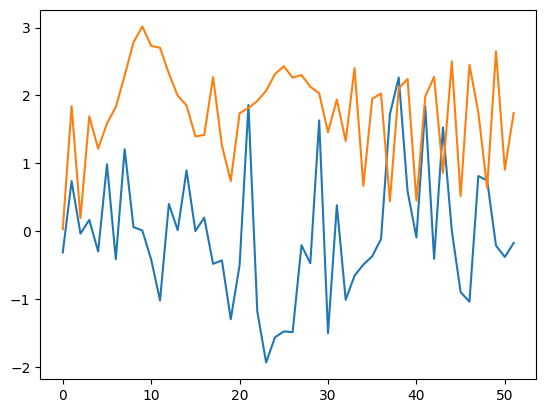

-3.110691077901354


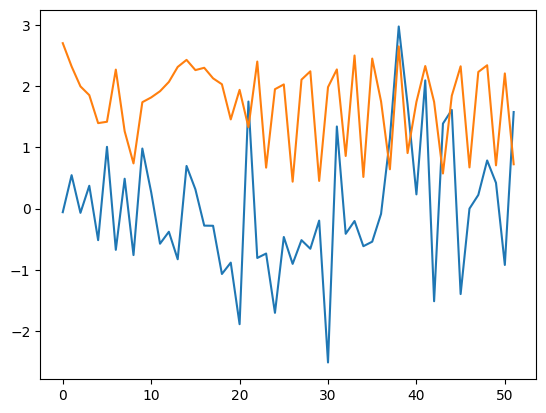

-3.244600922919857


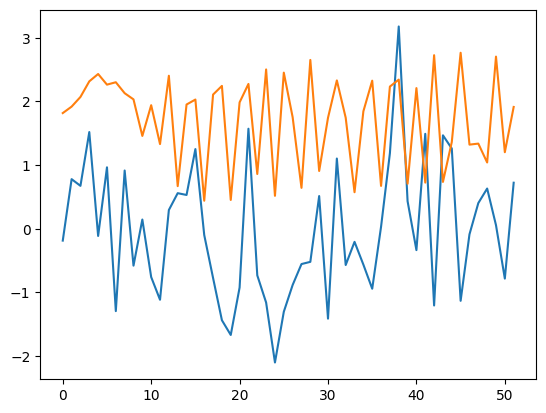

-3.443524076503116


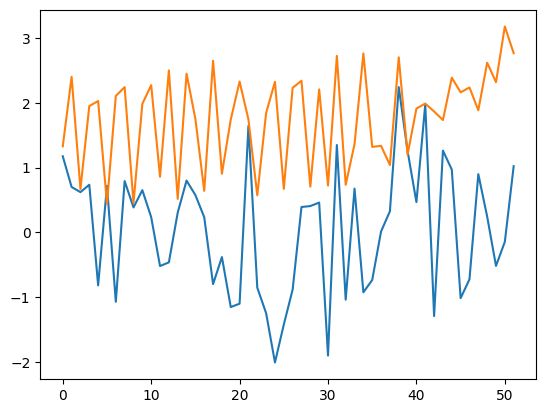

-4.309352633890891


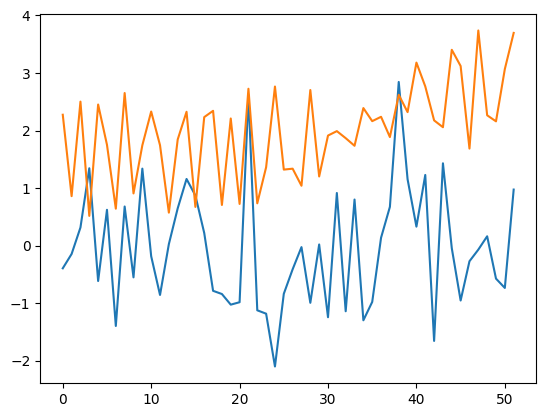

-3.572015039883892


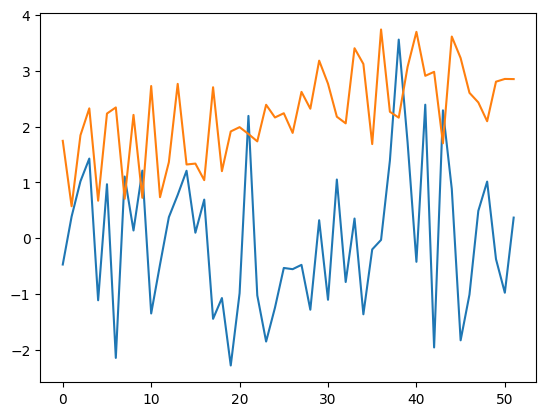

-3.840212236612551


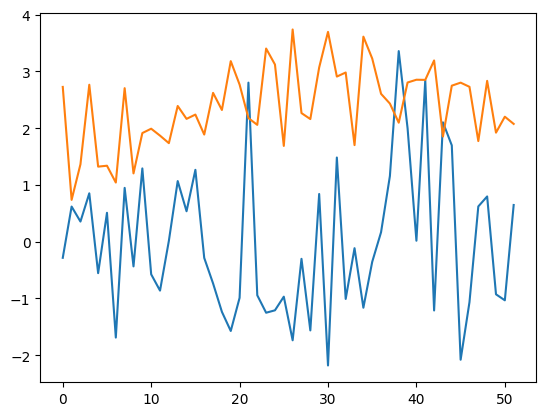

-3.179605351887168


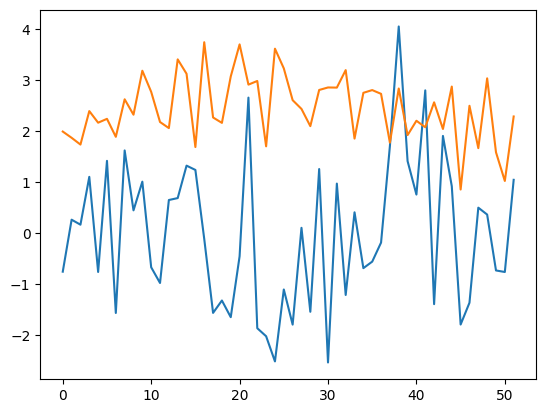

-2.995898670032306


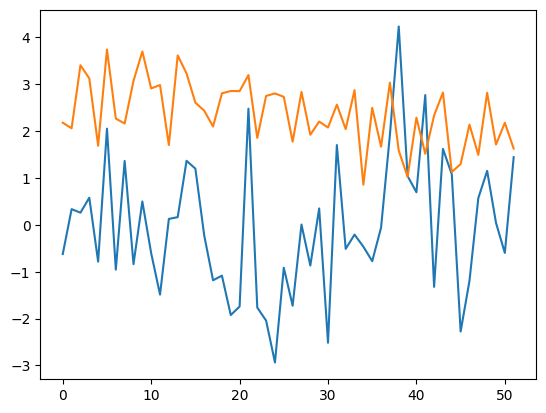

-3.057820951426832


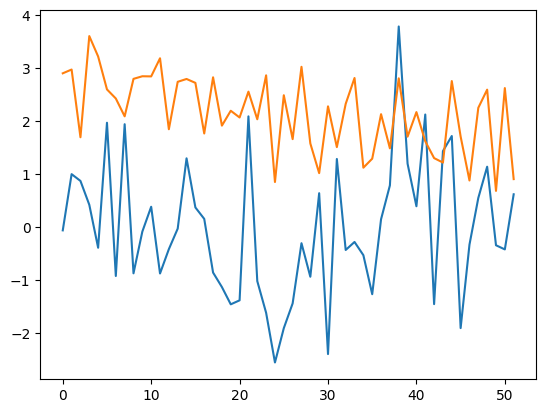

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
prediction = preds[52].detach().numpy()
print(prediction.shape)
print(X_full.shape)


for i in range(10):
    prediction_sample = prediction[i]
    real = X_full[i+1]

    r2 = r2_score(prediction_sample, real)
    print(r2)
    
    plt.plot(prediction_sample)
    plt.show
    plt.plot(real)
    plt.show()


AttributeError: 'dict' object has no attribute 'shape'